# Setup Personalizer Resource

In the next step, we setup and tune an Azure Personalizer Resource to prioritize the recommendations for individual users based on envinonrmental context and user preferences.

First, you must setup the Azure Personalizer Resource you will use by completing the following steps.


**1.** Create an [Azure Personalizer Resource](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesPersonalizer). **NOTE:** If you have already have a Personalizer resource you want to reuse, make sure to clear the data in the Azure portal for the resource, following these [instructions](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/how-to-manage-model#clear-data-for-your-learning-loop).

**NOTE:** The "Free F0" Pricing Tier will be sufficient for this example.

**2.** Go to the **Setup** page on your Personalizer resource in the Azure Portal and set the reward wait time of **10 minutes** as described [here](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/how-to-settings#configure-rewards-for-the-feedback-loop) and the update model frequency setting to **15 seconds** as described [here](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/how-to-settings#configure-model-update-frequency-for-model-training).


# Simulation Setup

When Personalizer is intialized, the suggestions are only successful between 20% to 30% of the time (indicated by the reward score of 1 meaning the suggestion matched the user's preference). After running many requests, the system improves.  This notebook simulates users interacting with a website to select groceries to purchase (10,000 orders are simulated) to prepare the Personalizer to make suggestions for our grocery customers. 

We will also show that we can run an offline evaluation based on the results of the simulations. This allows Personalizer to review the data and suggest a better learning policy. Then we will apply the new learning policy and run the notebook again with 4,000 requests and see if the loop performs better.

This notebook is based off this [tutorial](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/tutorial-use-azure-notebook-generate-loop-data).  

**How the simulation works**

For setting up the simulation, we selected a set of recommendations from the "Popular" results of our Intelligent Recommendations service.  You can choose to use any of the recommendation dataset options, but limit the results to 50 or less items for use in Personalizer.    We have generated a sample set of foods and customer preferences for use in this example.

In this notebook we will create a Personalizer loop _system_ which suggests a food based on the customers (eaters) and their preferences which are stored in a [customers dataset](data/eaters.json). Information about the foods available in a [foods dataset](data/foods.json).



A summary of the customer information is:

|Customer Name|Weather|Flavor|
|--|--|--|
|Alice<br>Bob<br>Cathy<br>Dave|Sunny<br>Rainy<br>Snowy|Salty<br>Sweet<br>Plain| 

To help Personalizer make the correct food selection for each person, the system also knows details about the foods.

|Temperature|Flavor Profile|Texture|Meal|
|--|--|--|--|
|Hot<br>Cold|Sweet<br>Savory|Crunchy<br>Soft<br>|Snack<br>Dessert|

The purpose of the Personalizer loop is to find the best match between the customers and the foods they like as much of the time as possible. 

**Rank and reward calls**

For each of the few thousand calls to the Personalizer service makes in our loop, the Azure notebook sends the **Rank** request to the REST API:

* A unique ID for the Rank/Request event
* Context - A random choice of the user, weather, and flavor desired - simulating a user on a website or mobile device looking for a purchase suggestion.
* Features - _All_ the food data - from which Personalizer makes a suggestion

The system receives the rank of the food choices, then compares that prediction with the customer's known choice for the same weather and flavor preference. If the known choice is the same as the predicted choice, the **Reward** of 1 is sent back to Personalizer. Otherwise the reward is 0. 

**Include the python modules**

Include the required python modules.

In [1]:
import json
import matplotlib.pyplot as plt
import random 
import requests
import time
import uuid
import datetime

**Set Personalizer resource key and name**

From the Azure portal, find your key and endpoint on the **Overview** page of your Personalizer resource. Change the value of `Your_Personalizer_url` to your Personalizer's Endpoint. Change the value of `Your_Personalizer_ResourceKey` to your Personalizer key (Go to "Manage Keys" and copy on of the values). 

In [2]:
# Replace 'personalization_base_url' and 'resource_key' with your valid endpoint values.  You can view these from the Personalizer Resource Azure Portal Page.
personalization_base_url = "Your_Personalizer_url"  
resource_key = "Your_Personalizer_ResourceKey"

## Function: Current Date Time

This function is used to note the start and end times of the iterative function, `iterations`.

In [3]:
# Print out current datetime
def currentDateTime():
    currentDT = datetime.datetime.now()
    print (str(currentDT))

## Function: Model Updated

The `get_last_updated` function prints out the last modified date and time that the model was updated. 

The function uses a GET REST API to [get model properties](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/GetModelProperties). 

In [5]:
# ititialize variable for model's last modified date
modelLastModified = ""

In [6]:
def get_last_updated(currentModifiedDate):
    
    print('-----checking model')
    
    # get model properties
    response = requests.get(personalization_model_properties_url, headers = headers, params = None)
    
    print(response)
    print(response.json())
    
    # get lastModifiedTime
    lastModifiedTime = json.dumps(response.json()["lastModifiedTime"])
    
    if (currentModifiedDate != lastModifiedTime):
        currentModifiedDate = lastModifiedTime
        print(f'-----model updated: {lastModifiedTime}')

## Function: Service Settings

This function validates and returns the state of the service.


In [7]:
def get_service_settings():
    
    print('-----checking service settings')
    
    # get learning policy
    response = requests.get(personalization_model_policy_url, headers = headers, params = None)
    
    print(response)
    print(response.json())
    
    # get service settings
    response = requests.get(personalization_service_configuration_url, headers = headers, params = None)
    
    print(response)
    print(response.json())


## Construct URLs & Load Data

Construct URLs for REST calls and read JSON data files to setup the customers and foods we will use in the simulation.

The steps are:
* build the URLs used for all API calls
* sets the security header using your Personalizer resource key 
* sets the random seed for the Rank event ID
* reads in the JSON data files
* calls `get_last_updated` method - learning policy has been removed in example output
* calls `get_service_settings` method



In [ ]:
# build URLs
personalization_rank_url = personalization_base_url + "personalizer/v1.0/rank"
personalization_reward_url = personalization_base_url + "personalizer/v1.0/events/" #add "{eventId}/reward"
personalization_model_properties_url = personalization_base_url + "personalizer/v1.0/model/properties"
personalization_model_policy_url = personalization_base_url + "personalizer/v1.0/configurations/policy"
personalization_service_configuration_url = personalization_base_url + "personalizer/v1.0/configurations/service"
headers = {'Ocp-Apim-Subscription-Key' : resource_key, 'Content-Type': 'application/json'}

# load user context (our customers' preferences)
users = "data/eaters.json"

# action features (the food choices available)
snacks = "data/foods.json"

# empty JSON for Rank request
requestpath = "data/example-rankrequest.json"

# initialize random
random.seed(time.time())

userpref = None 
rankactionsjsonobj = None 
actionfeaturesobj = None

with open(users) as handle:
    userpref = json.loads(handle.read())

with open(snacks) as handle:
    actionfeaturesobj = json.loads(handle.read())
    
with open(requestpath) as handle:
    rankactionsjsonobj = json.loads(handle.read())  
    
get_last_updated(modelLastModified)
get_service_settings()

print(f'Customer count {len(userpref)}')
print(f'Food count {len(actionfeaturesobj)}')

**Confirm first REST calls**

This previous cell is the first cell that calls out to Personalizer. 

Make sure the REST status code in the output is `<Response [200]>`. If you get an error, such as 404, but you are sure your resource key and name are correct, reload the notebook.

Verify that the output's `rewardWaitTime` and `modelExportFrequency` are both set to 15 seconds. 

Also, Make sure the count of customers and foods are both 4. If you get an error, check that you uploaded all 3 JSON files. 
    
```console
<Response [200]>
{'rewardWaitTime': 'PT10M', 'defaultReward': 0.0, 'rewardAggregation': 'earliest', 'explorationPercentage': 0.2, 'modelExportFrequency': 'PT15S', 'logRetentionDays': 90, 'lastConfigurationEditDate': '2022-07-12T16:40:44', 'learningMode': 'Online'}
Customer count 4
Food count 4

```


## Set up a metric chart

Later in this tutorial, the long running process of 10,000 requests is visible from the browser with an updating text box. It may be easier to see in a chart or as a total sum, when the long running process ends. To view this information, use the metrics provided with the resource. You can create the chart now that you have completed a request to the service, then refresh the chart periodically while the long running process is going.

1. In the Azure portal, select your Personalizer resource.
1. In the resource navigation, select **Metrics** underneath Monitoring. 
1. In the chart, select **Add metric**.
1. The resource and metric namespace are already set. You only need to select the metric of **successful calls** and the aggregation of **sum**.
1. Change the time filter to the last 4 hours.

    You should see three successful calls in the chart. 

## Function: Generate Unique Event ID

This function generates a unique ID for each rank call. The ID is used to identify the rank and reward call information. This value could come from a business process such as a web view ID or transaction ID.

In [9]:
def add_event_id(rankjsonobj):
    eventid = uuid.uuid4().hex
    rankjsonobj["eventId"] = eventid
    return eventid

## Function: Randomly Choose Customer, Weather, Flavor

This function selects a customer, the weather, and a flavor preference, then adds those items to the JSON object to send to the Rank request.

**NOTE:** If you modify the number of users, preferences, what the preference are, update this function.

A sample of the customers and their preferences is shown here - only some preferences are shown for brevity.

```json
{
  "Alice": {
    "Sunny": {
      "Plain": "ice cream",
      "Salty": "sliced cheese",
      "Sweet": "ice cream"
    }, ...
  },
    "Bob": {
    "Sunny": {
      "Plain": "cocoa drinks",
      "Salty": "sliced cheese",
      "Sweet": "ice cream"
    }, ...
  }
  "Cathy": {
    "Sunny": {
      "Plain": "popcorn",
      "Salty": "ice cream",
      "Sweet": "cocoa drinks"
    }..
  }
}
```


In [10]:
def add_random_user_and_contextfeatures(namesoption, flavoroption, weatheroption, rankjsonobj):   
    name = namesoption[random.randint(0,3)]  # we have 4 users to select from randomly
    flavor = flavoroption[random.randint(0,2)]  # we have 3 flavor choices
    weather = weatheroption[random.randint(0,2)]  # we have 3 weather options
    rankjsonobj['contextFeatures'] = [{'weather': weather, 'flavor': flavor, 'name': name}]
    return [name, flavor, weather]


## Function: Add Foods to Rank Request

This function adds the list of foods to the JSON object (`rankjsonobj`) to send to the Rank request. 

An example of a single food item's features is: 

```json

    {
      "id": "popcorn",
      "features": [
        {
          "type": "hot",
          "meal": "snack",
          "texture": "crunchy",
          "flavor": "savory"
            
        }
      ]
    }

```

In [11]:
def add_action_features(rankjsonobj):
    rankjsonobj["actions"] = actionfeaturesobj

## Function: Get Reward

This function is called after the Rank API is called, for each iteration.  It will compare the Rank API's prediction with known customer preferences (based on weather and flavor choice) to determine what Reward should be given (1 if it matches, 0 if it doesn't)

In [12]:
def get_reward_from_simulated_data(name, weather, flavor, prediction):
    if(userpref[name][weather][flavor] == str(prediction)):
        return 1 
    return 0

## Function: Iterations

The Iterations function runs the simulation by looping through calls to Rank and Reward as many times as configured (10,000 in this example).

The Iterations function does the following:

1.  Select a random Customer 
2.  Get the food list
3.  Send the customer and food list to the Rank API. 
4.  Compares the prediction returned by the Rank API with the customer's known preferences and determines the reward (1 if it matches, 0 if not) 
5.  Send the reward score back to the Personalizer service. 

The loop runs for `num_requests` times - Personalizer needs a few thousand calls to Rank and Reward to create a model. 

**NOTE:** If changing the preference names, or adding/removing any, this function should be modified.

An example of the JSON sent to the Rank API follows. The list of foods (actions) is not complete, for brevity, but all are sent. You can see the entire JSON for foods in `foods.json`.

```json
{
	'contextFeatures': [
		{
			'weather': 'Rainy', 
			'flavor': 'Salty', 
			'name': 'Dave'
		}
	], 
	'actions': [
		{
		'id': 'popcorn', 
		'features': [{'type': 'hot', 'meal': 'snack', 'texture': 'crunchy', 'flavor': 'savory'}]
		},

		rest of the foods list are the actions to select from...
	
	], 
	'excludedActions': [], 
	'eventId': '3c86b4ba96204a66b811876bfb6439b4', 'deferActivation': False
}
```

JSON response from the Rank API, indicating all 4 actions have equal probability.  In this case, it will select popcorn.

```
{
	'ranking': [
		{'id': 'popcorn', 'probability': 0.25}, 
		{'id': 'sliced cheese', 'probability': 0.25}, 
		{'id': 'cocoa drinks', 'probability': 0.25}, 
		{'id': 'ice cream', 'probability': 0.25}
	], 
	'eventId': '3c86b4ba96204a66b811876bfb6439b4', 
	'rewardActionId': 'popcorn'
}
```

Finally, each loop shows the random selection of user, weather, flavor choice, and what reward is determined. The reward of 1 indicates the Personalizer resource selected a food for the given user, weather, and flavor that matched their preferences.

In this example, Dave's preferences match the selection of popcorn, so the Reward is 1.

```console
Customer: Dave
Flavor Preference: Salty 
Weather: Rainy
Suggestion: popcorn 
Reward: 1
```

The function uses:

* Rank: a POST REST API to [get rank](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/Rank). 
* Reward: a POST REST API to [report reward](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/Reward).

In [13]:
def iterations(n, modelCheck, jsonFormat):

    i = 1
    
    # default reward value - assumes failed prediction
    reward = 0

    # Print out dateTime
    #currentDateTime()

    # collect results to aggregate in graph
    total = 0
    rewards = []
    count = []

    # default list of user, weather, time of day
    namesopt = ['Dave','Alice', 'Bob', 'Cathy']
    flavoropt = ['Salty', 'Sweet', 'Plain']
    weatheropt = ['Sunny', 'Rainy', 'Snowy']

   
    while(i <= n):

        # create unique id to associate with an event
        eventid = add_event_id(jsonFormat)

        # generate a random sample
        [name, flavor, weather] = add_random_user_and_contextfeatures(namesopt, flavoropt, weatheropt, jsonFormat)

        # add action features to rank
        add_action_features(jsonFormat) 

        # show JSON to send to Rank
        #print('To: ', jsonFormat)    

        # choose an action - get prediction from Personalizer
        response = requests.post(personalization_rank_url, headers = headers, params = None, json = jsonFormat)

        # show Rank prediction 
        #print ('From: ',response.json())    

        # compare personalization service recommendation with the simulated data to generate a reward value
        prediction = json.dumps(response.json()["rewardActionId"]).replace('"','')
        reward = get_reward_from_simulated_data(name, weather, flavor, prediction)

        # show result for iteration
        print(f'   {i} {currentDateTime()} {name} {weather} {flavor} {prediction} {reward} ')

        # send the reward to the service 
        response = requests.post(personalization_reward_url + eventid + "/reward", headers = headers, params= None, json = { "value" : reward })

        # for every N rank requests, compute total correct  
        total = total + reward

        # every N iteration, get last updated model date and time
        if(i % modelCheck == 0):

            print("**** 10% of loop found")
            get_last_updated(modelLastModified) 

        # aggregate so chart is easier to read
        if(i % 100 == 0):
            print("**** aggregating rewards")
            rewards.append(total)
            count.append(i)
            total = 0

        i = i + 1
        
    # Print out dateTime
    #currentDateTime()
    
    return [count, rewards]

# Run Simulation

## Run for 10,000 iterations

Run the Personalizer loop for 10,000 iterations. This is a long running event - at least an hour, can be more depending on your resources. Do not close the browser running the notebook, you will continue to see results scroll while it runs. Refresh the metrics chart in the Azure portal periodically to see the total calls to the service. When you have around 20,000 calls, a rank and reward call for each iteration of the loop, the iterations are done. 


In [ ]:
# max iterations
num_requests = 10000

# check last mod date N% of time - currently 10%
lastModCheck = int(num_requests * .10)

jsonTemplate = rankactionsjsonobj

# main iterations
[count, rewards] = iterations(num_requests, lastModCheck, jsonTemplate)

Example of output:

```json
2023-02-02 22:27:32.234434
   1 None Dave Sunny Salty ice cream 0 
2023-02-02 22:27:32.327635
   2 None Dave Sunny Sweet ice cream 0 
2023-02-02 22:27:32.465137
   3 None Bob Sunny Salty cocoa drinks 0 
2023-02-02 22:27:32.602612
   4 None Cathy Sunny Plain ice cream 0 
2023-02-02 22:27:32.705047
   5 None Cathy Rainy Plain ice cream 0 
2023-02-02 22:27:32.785077
   6 None Alice Sunny Sweet ice cream 1 
2023-02-02 22:27:32.865338
   7 None Bob Rainy Plain sliced cheese 0 
```



## Function: Chart Results

Create a chart from the `count` and `rewards` tracked in the simulation to see if there was improvement.

In [15]:
def createChart(x, y):
    plt.plot(x, y)
    plt.xlabel("Batch of rank events")
    plt.ylabel("Correct recommendations per batch")
    plt.show()

## Review Results of Simulation

Run the `createChart` function with the accumlated values from the iterations.

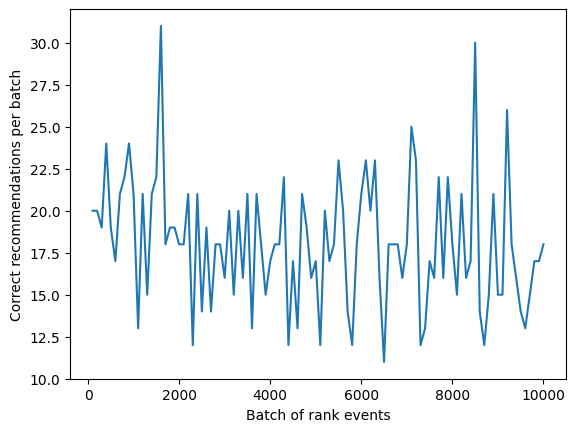

In [16]:
createChart(count, rewards) 

This chart shows the success of the model for the current default learning policy. 

The ideal target that by the end of the test, the loop is averaging a success rate that is close to one hundred percent minus the exploration. The default setting of exploration is 20%. 

`100-20=80`

This exploration setting is found in the Azure portal, for the Personalizer resource, in the Configurations tab, under the RESOURCE MANAGEMENT section 

# Offline Evaluation  (Optional)

To run this option you will likely need to be in the non-free pricing tier to have enough transactions available to run this.

## Run an offline evaluation

In order to find a better learning policy, based on your data to the Rank API, run an [offline evaluation](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/concepts-offline-evaluation) in the portal for your Personalizer loop.

1. In the Azure portal, open the Personalizer resource's **Optimize** page.
1. Under **Manual Evaluations**, select **+ Create Evaluation**.
1. Enter the required data of evaluation name, and date range for the loop evaluation. The date range should include the days you are focusing on for your evaluation (in our case, the current day(s) you ran the 10,000 iterations).  You may need to type the date in as the datepicker defaults to the current day. 

    The purpose of running this offline evaluation is to determine if there is a better learning policy for the features and actions used in this loop. To find that better learning policy, make sure **Optimization discovery** is turned on.

1. Select **OK** to begin the evaluation. 
1. This **Evaluations** page lists the new evaluation and its current status. Depending on how much data you have, this evaluation can take some time. You can come back to this page after a few minutes to see the results. 
1. When the evaluation is completed, select the evaluation then select **Compare the score of your application with other potential learning settings**. This shows the available learning policies and how they would behave with the data. 
1. Select the top-most learning policy in the table and select **Apply**. This applies the _best_ learning policy to your model and retrains. 

## Configure for new Learning Policy


Before running again, change the update model frequency to 5 minutes.

1. In the Azure portal, still on the Personalizer resource, selec the Configurations tab, under the Resource Management section. 
1. Change the **model update frequency**  to 5 minutes and select **Save**.

Learn more about the [reward wait time](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/concept-rewards#reward-wait-time) and [model update frequency](https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/how-to-settings#model-update-frequency).

Then verify the new learning policy and times are set.

In [ ]:
get_service_settings()

Verify that the output's `modelExportFrequency` are both set to 5 minutes. 
    
```console
-----checking service settings
<Response [200]>
{}...'arguments': '--cb_explore_adf --epsilon 0.20000000298023224 --dsjson --cb_type mtr --marginal i -q Fi -q Fj -l 0.1 --power_t 0'}
<Response [200]>
{'rewardWaitTime': 'PT10M', 'defaultReward': 0.0, 'rewardAggregation': 'earliest', 'explorationPercentage': 0.2, 'modelExportFrequency': 'PT5M', 'logRetentionDays': 90, 'lastConfigurationEditDate': '2022-07-12T18:26:32', 'learningMode': 'Online'}
```

## Run 4,000 iterations with new Learning Policy

Run the loop again, but for only 4,000 iterations. Refresh the metrics chart in the Azure portal periodically to see the total calls to the service.  This is a long running event. Do not close the browser running the notebook. Refresh the metrics chart in the Azure portal periodically to see the total calls to the service. When you have around 8,000 calls showing in the chart, a rank and a reward call for each iteration of the loop, the iterations are done. 



In [ ]:
# max iterations
num_requests = 4000

# check last mod date N% of time - currently 10%
lastModCheck2 = int(num_requests * .10)

jsonTemplate2 = rankactionsjsonobj

# main iterations
[count2, rewards2] = iterations(num_requests, lastModCheck2, jsonTemplate2)

Example of output:

```json
2023-02-02 22:45:19.879721
   2396 None Cathy Snowy Sweet ice cream 0 
2023-02-02 22:45:19.950750
   2397 None Bob Sunny Plain ice cream 0 
2023-02-02 22:45:20.014116
   2398 None Dave Snowy Salty popcorn 0 
2023-02-02 22:45:20.084015
   2399 None Bob Sunny Sweet ice cream 1 
2023-02-02 22:45:20.151643
   2400 None Cathy Rainy Salty ice cream 0 
**** 10% of loop found
-----checking model
<Response [200]>
{'creationTime': '2023-02-01T21:48:39+00:00', 'lastModifiedTime': '2023-02-02T17:50:17+00:00'}
-----model updated: "2023-02-02T17:50:17+00:00"
**** aggregating rewards
```

## Review Results


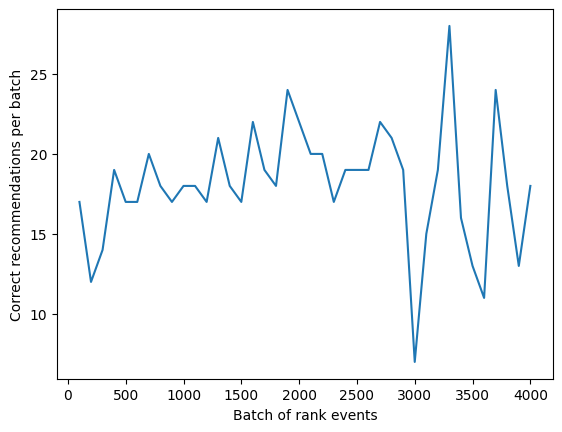

In [19]:
createChart(count2,rewards2)

The second chart should show a visible increase in Rank predictions aligning with user preferences fairly early in the iterations run, proving it's a better learning policy for us to use with our grocery recommender, at least for now!  You will want to continue to monitor the performance over time as more users interact with the system to determine if changes should be made.